# Fokker-Planck equation for Quantum Radiation Reaction

In this notebook we show some of the main analytical results from the paper.

Outline:
- Distribution Functions using the $\chi$ expansion for the moments
- Moments of the Distribution Functions (former approach)
- Entropy and Auto-correlation funcction
- Polynomial approximation to the Fokker-Planck operator coefficients, and direct analytical solution to the Fokker-Planck equation in the low $\chi$ regime

In [1]:
import glob as glob
import numpy as np
from numpy import pi, exp, log, sin, cos, sqrt
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.special import kv, iv, erf
from scipy.integrate import quad
from scipy.constants import c, alpha, hbar, e, m_e, e, epsilon_0 # physical constants
from scipy.special import gamma, hyp2f1
from tqdm import trange
from scipy.optimize import minimize, minimize_scalar
import PDEsolverQRR
from PDEsolverQRR import *

def get_mean_cl(t, chi0, g0=1800):
    Rc = alpha * 1800 * chi0
    g = 1/(1+2*Rc*t/3)
    return g*g0

def get_mean(t, chi0, g0=1800):
    Rc = alpha * 1800 * chi0
    g = 1/(1+2*Rc*t/3) + 55*chi0/(8*sqrt(3)*(1+2/3*Rc*t)**2) * 0.5 * 3*log(1+2*Rc*t/3)
    return g*g0

def get_spread(t, chi0, g0=1800, s0=0):
    Rc = alpha * 1800 * chi0
    return g0/(1+2*Rc*t/3)**2 * sqrt(s0**2 + 55*Rc*chi0*t/(24*sqrt(3)))
    
def get_entropy(t, chi0, g0=1800, s0=0):
    Rc = alpha * 1800 * chi0
    sig = get_spread(t, chi0, g0, s0)
    return log(sig) + 0.5*(1+log(2*pi))

def NormalDist(x, t, chi0):
    mu = get_mean(t, chi0)
    sig = get_spread(t, chi0)
    return 1/sqrt(2*pi*sig**2) * exp(-0.5*(x-mu)**2/sig**2)

def get_t(g, chi0, g0=1800):
    Rc = alpha * 1800 * chi0
    def func(t):
        return np.abs( get_mean(t, chi0, g0) - g )**2
    t0 = 3/(2*Rc) * (g0/g - 1)
    #result = minimize(func, t0, args=(), method='Powell' )
    result = minimize_scalar(func, bounds=(0,30), method='bounded')
    return result.x

# Compute the autocorrelation function
def autocorrelation(x, q, max_lag):
    x = np.transpose(x)
    q = np.transpose(q)
    num_traj, N = x.shape
    autocorr = np.zeros(max_lag)
    for lag in trange(max_lag):
        # Calculate autocorrelation for each lag
        gt = q[:, : N//2] * x[:, : N//2]
        gtptau = q[:, lag:lag+N//2] * x[:, lag:lag+N//2]
        autocov = np.sum( gt * gtptau , axis=1) # mean
        autocorr[lag] = np.mean(autocov)
    # Normalize
    autocorr /= autocorr[0]
    return autocorr

# Distributions

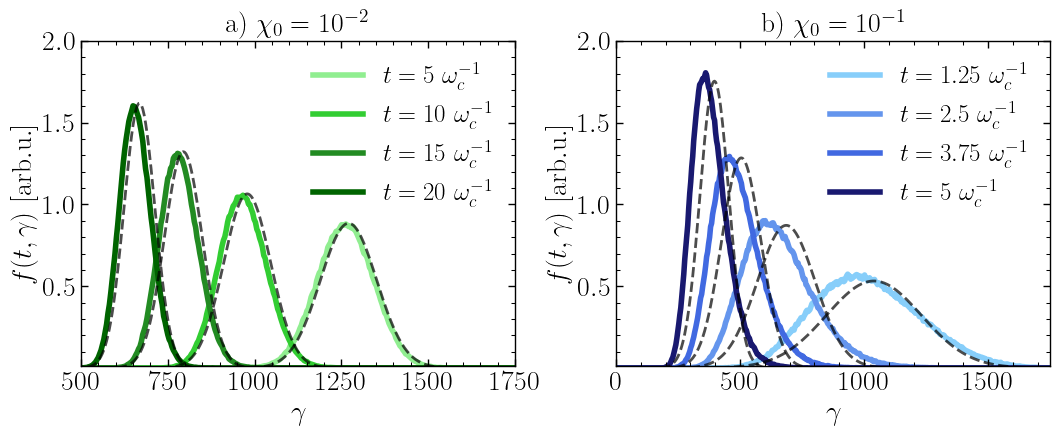

In [2]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

OSIRISlinewidth = 4
nrm_glob0 = 0.9
nrm_glob1 = 1.5
files_electrons2 = glob.glob("OSIRIS/osiris_s00/chi2/MS/PHA/gamma/electrons/*.h5")
files_electrons2.sort()
#
tmax = 20.0
filef = h5py.File(files_electrons2[0], 'r')
dt = filef['SIMULATION'].attrs["DT"][0]
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.abs(np.array(filef['gamma']))
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
#
for i in range(len(files_electrons2)):
    filef = h5py.File(files_electrons2[i], 'r')
    TIME = filef.attrs["TIME"][0]
    if(np.abs(TIME-5.0)<0.1/2):
        #print(TIME, 5.0/20.0*tmax)
        electrondNdg5 = np.abs(np.array(filef['gamma']))
    if(np.abs(TIME-10.0)<0.1/2):
        #print(TIME, 10.0/20.0*tmax)
        electrondNdg10 = np.abs(np.array(filef['gamma']))
    if(np.abs(TIME-15.0)<0.1/2):
        #print(TIME, 15.0/20.0*tmax)
        electrondNdg15 = np.abs(np.array(filef['gamma']))
    if(np.abs(TIME-20.0)<0.1/2):
        #print(TIME, 20.0/20.0*tmax)
        electrondNdg20 = np.abs(np.array(filef['gamma']))
#
nrm1 = 1e9
colors = ["LightGreen", "LimeGreen", "ForestGreen", "DarkGreen"]
#colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
axes[0].plot(x, electrondNdg5*nrm1 * nrm_glob0, label=r'$t = 5~\omega_c^{-1}$', linewidth=OSIRISlinewidth, color=colors[0])
axes[0].plot(x, electrondNdg10*nrm1 * nrm_glob0, label=r'$t = 10~\omega_c^{-1}$', linewidth=OSIRISlinewidth, color=colors[1])
axes[0].plot(x, electrondNdg15*nrm1 * nrm_glob0, label=r'$t = 15~\omega_c^{-1}$', linewidth=OSIRISlinewidth, color=colors[2])
axes[0].plot(x, electrondNdg20*nrm1 * nrm_glob0, label=r'$t = 20~\omega_c^{-1}$', linewidth=OSIRISlinewidth, color=colors[3])


files_electrons1 = glob.glob("OSIRIS/osiris_s00/chi1/MS/PHA/gamma/electrons/*.h5")
files_electrons1.sort()
#
tmax = 10.0
filef = h5py.File(files_electrons1[0], 'r')
dt = filef['SIMULATION'].attrs["DT"][0]
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.abs(np.array(filef['gamma']))
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
#
lenn = len(files_electrons1)
#
filef = h5py.File(files_electrons1[ int(lenn * 0.125) ], 'r')
electrondNdg5 = np.abs(np.array(filef['gamma']))
filef = h5py.File(files_electrons1[ int(lenn * 0.25) ], 'r')
electrondNdg10 = np.abs(np.array(filef['gamma']))
filef = h5py.File(files_electrons1[ int(lenn * 0.375) ], 'r')
electrondNdg15 = np.abs(np.array(filef['gamma']))
filef = h5py.File(files_electrons1[ int(lenn * 0.5) ], 'r')
electrondNdg20 = np.abs(np.array(filef['gamma']))
#
nrm2 = 1e9
colors = ["LightSkyBlue", "CornflowerBlue", "RoyalBlue", "MidnightBlue"]
axes[1].plot(x, electrondNdg5*nrm2 * nrm_glob1, label=r'$t = 1.25~\omega_c^{-1}$', linewidth=OSIRISlinewidth, color=colors[0])
axes[1].plot(x, electrondNdg10*nrm2 * nrm_glob1, label=r'$t = 2.5~\omega_c^{-1}$', linewidth=OSIRISlinewidth, color=colors[1])
axes[1].plot(x, electrondNdg15*nrm2 * nrm_glob1, label=r'$t = 3.75~\omega_c^{-1}$', linewidth=OSIRISlinewidth, color=colors[2])
axes[1].plot(x, electrondNdg20*nrm2 * nrm_glob1, label=r'$t = 5~\omega_c^{-1}$', linewidth=OSIRISlinewidth, color=colors[3])

# Normal Distribution - solution
nrm = 2e2
sty = 'k--'
alp = 0.7
mrksz = 3
axes[0].plot(x, NormalDist(x, 5, 1e-2)*nrm * nrm_glob0, sty, alpha=alp, markersize=mrksz)
axes[0].plot(x, NormalDist(x, 10, 1e-2)*nrm * nrm_glob0, sty, alpha=alp, markersize=mrksz)
axes[0].plot(x, NormalDist(x, 15, 1e-2)*nrm * nrm_glob0, sty, alpha=alp, markersize=mrksz)
axes[0].plot(x, NormalDist(x, 20, 1e-2)*nrm * nrm_glob0, sty, alpha=alp, markersize=mrksz)
#
nrm = 1.7e2
axes[1].plot(x, NormalDist(x, 1.25, 1e-1)*nrm * nrm_glob1, sty, alpha=alp, markersize=mrksz)
axes[1].plot(x, NormalDist(x, 2.5, 1e-1)*nrm * nrm_glob1, sty, alpha=alp, markersize=mrksz)
axes[1].plot(x, NormalDist(x, 3.75, 1e-1)*nrm * nrm_glob1, sty, alpha=alp, markersize=mrksz)
axes[1].plot(x, NormalDist(x, 5, 1e-1)*nrm * nrm_glob1, sty, alpha=alp, markersize=mrksz)

asp = 3/4
axes[0].set_xlim(500,1750)
axes[1].set_xlim(0,1750)
for i in range(2):
    axes[i].legend(fontsize=18)
    axes[i].set_ylim(1e-2,2)
    #axes[i].set_yscale('log')
    xmin, xmax = axes[i].get_xlim()
    ymin, ymax = axes[i].get_ylim()
    axesratio = (ymax-ymin)/(xmax-xmin)
    axes[i].set_aspect(aspect=asp/axesratio)
    axes[i].set_xlabel(r'$\gamma$')
    axes[i].set_ylabel(r'$f(t,\gamma) ~[\mathrm{arb. u.}]$')
axes[0].set_title(r'a) $\chi_0=10^{-2}$')
axes[1].set_title(r'b) $\chi_0=10^{-1}$')

# Ito process solution
"""
chi0 = 1e-2
wp = 2.442805570516893e11 * chi0/(1e-3)
for t in [5,10,15,20]:
    axes[0].plot(x, 1.75*dNedgf_th(x, t/wp, 1e-2) * nrm * nrm_glob0, 'r--')
#
chi0 = 1e-1
wp = 2.442805570516893e11 * chi0/(1e-3)
for t in [1.25,2.5,3.75,5]:
    axes[1].plot(x, 2.7*dNedgf_th(x, t/wp, 1e-1) * nrm * nrm_glob0, 'r--')
"""

plt.tight_layout()
#plt.savefig('FokkerPlanckSolution_distribution.pdf', transparent=True)
plt.show()

# Average energy and spread

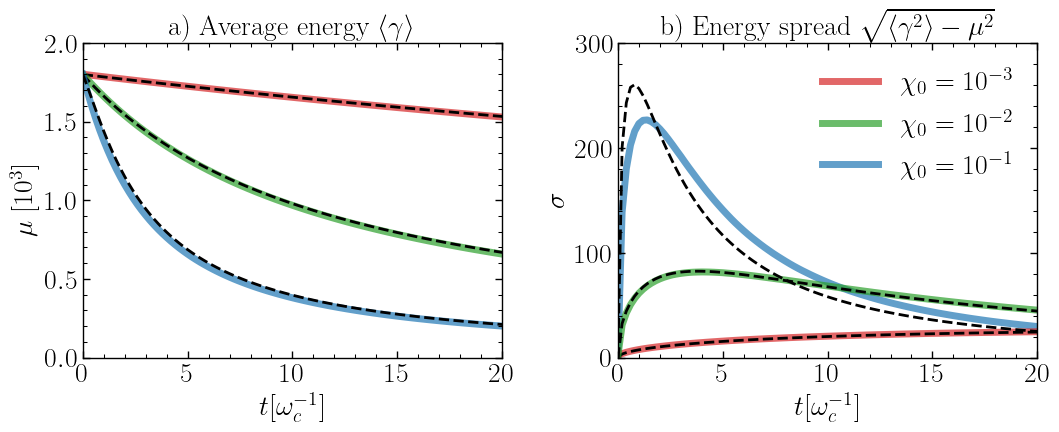

In [3]:
OSIRISlinewidth = 5
#colors = ["crimson","tomato","orange"]
colors = ["tab:red","tab:green","tab:blue"]
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

files_electrons = glob.glob("OSIRIS/osiris_s00/chi3/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
filef = h5py.File(files_electrons[0], 'r')
dt = filef['SIMULATION'].attrs["DT"][0]
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.abs(np.array(filef['gamma']))
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
tmax = 20.0
tlst = np.linspace(0,tmax,len(files_electrons))
avglst = np.zeros(len(files_electrons))
siglst = np.zeros(len(files_electrons))
for i in range(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    TIME = filef.attrs["TIME"][0]
    y = np.abs(np.array(filef['gamma']))
    avg = np.trapz(x * y, x)/np.trapz(y, x)
    sig = sqrt( np.trapz( (x-avg)**2 * y, x)/np.trapz(y, x) )
    avglst[i] = avg
    siglst[i] = sig
axes[0].plot(tlst, avglst*1e-3, color=colors[0], linewidth=OSIRISlinewidth, alpha=0.7)
axes[0].plot(tlst, get_mean(tlst, 1e-3)*1e-3, 'k--')
axes[1].plot(tlst, siglst, color=colors[0], label=r'$\chi_0=10^{-3}$', linewidth=OSIRISlinewidth, alpha=0.7)
#
axes[1].plot(tlst, get_spread(tlst, 1e-3), 'k--' )

files_electrons = glob.glob("OSIRIS/osiris_s00/chi2/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
filef = h5py.File(files_electrons[0], 'r')
dt = filef['SIMULATION'].attrs["DT"][0]
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.abs(np.array(filef['gamma']))
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
tmax = 20.0
tlst = np.linspace(0,tmax,len(files_electrons))
avglst = np.zeros(len(files_electrons))
siglst = np.zeros(len(files_electrons))
for i in range(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    TIME = filef.attrs["TIME"][0]
    y = np.abs(np.array(filef['gamma']))
    avg = np.trapz(x * y, x)/np.trapz(y, x)
    sig = sqrt( np.trapz( (x-avg)**2 * y, x)/np.trapz(y, x) )
    avglst[i] = avg
    siglst[i] = sig
axes[0].plot(tlst, avglst*1e-3, color=colors[1], linewidth=OSIRISlinewidth, alpha=0.7)
axes[0].plot(tlst, get_mean(tlst, 1e-2)*1e-3, 'k--')
axes[1].plot(tlst, siglst, color=colors[1], label=r'$\chi_0=10^{-2}$', linewidth=OSIRISlinewidth, alpha=0.7)
#
axes[1].plot(tlst, get_spread(tlst, 1e-2), 'k--' )

files_electrons = glob.glob("OSIRIS/osiris_s00/chi1/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
filef = h5py.File(files_electrons[0], 'r')
dt = filef['SIMULATION'].attrs["DT"][0]
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.abs(np.array(filef['gamma']))
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
tmax = 10.0
tlst = np.linspace(0,tmax,len(files_electrons))
avglst = np.zeros(len(files_electrons))
siglst = np.zeros(len(files_electrons))
for i in range(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    TIME = filef.attrs["TIME"][0]
    y = np.abs(np.array(filef['gamma']))
    avg = np.trapz(x * y, x)/np.trapz(y, x)
    sig = sqrt( np.trapz( (x-avg)**2 * y, x)/np.trapz(y, x) )
    avglst[i] = avg
    siglst[i] = sig
axes[0].plot(tlst*2, avglst*1e-3, color=colors[2], linewidth=OSIRISlinewidth, alpha=0.7)
axes[0].plot(tlst*2, get_mean(tlst, 1e-1)*1e-3, 'k--')
axes[1].plot(tlst*2, siglst, color=colors[2], label=r'$\chi_0=10^{-1}$', linewidth=OSIRISlinewidth, zorder=-9999, alpha=0.7)
#
axes[1].plot(tlst*2, get_spread(tlst, 1e-1), 'k--' )
axes[1].legend()

axes[0].set_xlabel(r'$t[\omega_c^{-1}]$')
axes[1].set_xlabel(r'$t[\omega_c^{-1}]$')
axes[0].set_ylabel(r'$\mu ~[10^3]$')
axes[1].set_ylabel(r'$\sigma$')
axes[0].set_xlim([0,20])
axes[1].set_xlim([0,20])
axes[0].set_ylim([0,2])
axes[1].set_ylim([0,300])
asp = 3/4
xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes[0].set_aspect(aspect=asp/axesratio)
xmin, xmax = axes[1].get_xlim()
ymin, ymax = axes[1].get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes[1].set_aspect(aspect=asp/axesratio)
axes[0].set_title(r'a) Average energy $\langle \gamma \rangle$')
axes[1].set_title(r'b) Energy spread $\sqrt{ \langle \gamma^2 \rangle - \mu^2 }$')
plt.tight_layout()
#plt.savefig('FokkerPlanckSolution_averagespread.pdf',transparent=True)
plt.show()

# Full distribution over time

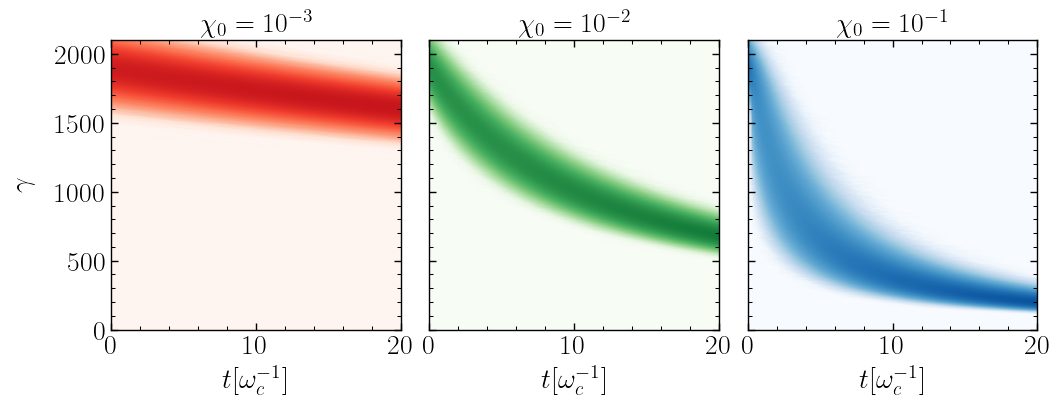

In [4]:
files_electrons = glob.glob("OSIRIS/osiris_s90/chi3/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
filef = h5py.File(files_electrons[0], 'r')
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.array(filef['gamma'])
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
fdist3 = np.zeros((len(files_electrons),len(y)))
for i in range(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    dt = filef['SIMULATION'].attrs["DT"][0]
    fdist3[i,:] = np.abs( np.array(filef['gamma']) )
#
files_electrons = glob.glob("OSIRIS/osiris_s90/chi2/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
filef = h5py.File(files_electrons[0], 'r')
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.array(filef['gamma'])
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
fdist2 = np.zeros((len(files_electrons),len(y)))
for i in range(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    dt = filef['SIMULATION'].attrs["DT"][0]
    fdist2[i,:] = np.abs( np.array(filef['gamma']) )
#
files_electrons = glob.glob("OSIRIS/osiris_s90/chi1/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
filef = h5py.File(files_electrons[0], 'r')
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.array(filef['gamma'])
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
fdist1 = np.zeros((len(files_electrons),len(y)))
for i in range(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    dt = filef['SIMULATION'].attrs["DT"][0]
    fdist1[i,:] = np.abs( np.array(filef['gamma']) )

# evolution of distribution function
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11,5), gridspec_kw={'width_ratios': [1, 1, 1]})
gmax = 2100
gmin = 0
frac = 0.0467
fmin = 1e-12
vmin = np.log10(fmin)
vmax = -8
axes[0].imshow(np.log10(fdist3+fmin).T, interpolation='bilinear', extent=[0, 20, gmin, gmax], origin='lower', cmap='Reds', vmin=vmin, vmax=vmax) #YlGnBu
axes[0].set_xlabel(r'$t[\omega_c^{-1}]$')
axes[0].set_ylabel(r'$\gamma$',labelpad=15)
axes[0].set_title(r'$\chi_0=10^{-3}$')

axes[1].imshow(np.log10(fdist2+fmin).T, interpolation='bilinear', extent=[0, 20, gmin, gmax], origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
axes[1].set_xlabel(r'$t[\omega_c^{-1}]$')
axes[1].set_title(r'$\chi_0=10^{-2}$')

im0 = axes[2].imshow(np.log10(fdist1+fmin).T, interpolation='bilinear', extent=[0, 20, gmin, gmax], origin='lower', cmap='Blues', vmin=vmin, vmax=vmax)
axes[2].set_xlabel(r'$t[\omega_c^{-1}]$')
#cbar0 = fig.colorbar(im0, ax=axes[2],fraction=frac, pad=0.02)
#cbar0.set_label(r'$\log (f_e(t,\gamma))$',labelpad=1,y=0.5)
axes[2].set_title(r'$\chi_0=10^{-1}$')

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
# aspect
for i in range(3):
    xmin, xmax = axes[i].get_xlim()
    ymin, ymax = axes[i].get_ylim()
    axesratio = (ymax-ymin)/(xmax-xmin)
    axes[i].set_aspect(aspect=1/axesratio)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)  # Adjust this value to control horizontal spacing
#plt.savefig('FokkerPlanckSolution_triptych.pdf',transparent=True)
plt.show()

# Entropy and Auto-Correlation

In [5]:
# Compute Entropy
mlplS = 1e-15

# chi 1e-3
files_electrons = glob.glob("OSIRIS/osiris_s00/chi3/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
#
tmax = 20.0
filef = h5py.File(files_electrons[0], 'r')
dt = filef['SIMULATION'].attrs["DT"][0]
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.abs(np.array(filef['gamma']))
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
#
tlst_chi = np.linspace(1e-10,tmax,len(files_electrons))
Slst_chi = np.zeros_like(tlst_chi)
for i in trange(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    f = np.abs(np.array(filef['gamma']))
    maxf = np.max(f)
    f += mlplS
    Slst_chi[i] = -np.sum( f * log(f) ) / np.sum(f)
tlst_chi3 = np.copy(tlst_chi)
Slst_chi3 = np.copy(Slst_chi)

# chi 1e-2
files_electrons = glob.glob("OSIRIS/osiris_s00/chi2/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
#
tmax = 20.0
filef = h5py.File(files_electrons[0], 'r')
dt = filef['SIMULATION'].attrs["DT"][0]
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.abs(np.array(filef['gamma']))
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
#
tlst_chi = np.linspace(1e-10,tmax,len(files_electrons))
Slst_chi = np.zeros_like(tlst_chi)
for i in trange(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    f = np.abs(np.array(filef['gamma']))
    maxf = np.max(f)
    f += mlplS
    Slst_chi[i] = -np.sum( f * log(f) ) / np.sum(f)
tlst_chi2 = np.copy(tlst_chi)
Slst_chi2 = np.copy(Slst_chi)


# chi 1e-1
files_electrons = glob.glob("OSIRIS/osiris_s00/chi1/MS/PHA/gamma/electrons/*.h5")
files_electrons.sort()
#
tmax = 10.0
filef = h5py.File(files_electrons[0], 'r')
dt = filef['SIMULATION'].attrs["DT"][0]
AXIS1 = np.array(filef['AXIS']['AXIS1'])
y = np.abs(np.array(filef['gamma']))
x = np.linspace(np.min(AXIS1),np.max(AXIS1),len(y))
#
tlst_chi = np.linspace(1e-10,tmax,len(files_electrons))
Slst_chi = np.zeros_like(tlst_chi)
for i in trange(len(files_electrons)):
    filef = h5py.File(files_electrons[i], 'r')
    f = np.abs(np.array(filef['gamma']))
    maxf = np.max(f)
    f += mlplS
    Slst_chi[i] = -np.sum( f * log(f) ) / np.sum(f)
tlst_chi1 = np.copy(tlst_chi)
Slst_chi1 = np.copy(Slst_chi)

100%|███████████████████████████████████████| 101/101 [00:00<00:00, 5710.38it/s]


In [6]:
# compute Autocorrelation function from RAW files trajectories
files_electrons2 = glob.glob("OSIRIS/osiris_s00/chi3/MS/RAW/electrons/*.h5")
files_electrons2.sort()
filef = h5py.File(files_electrons2[0], 'r')
enepath = np.abs(np.array(filef['ene']))
TIME0 = filef.attrs["TIME"][0]
filef = h5py.File(files_electrons2[1], 'r')
TIME1 = filef.attrs["TIME"][0]
dt = TIME1-TIME0
enedist = np.zeros((len(files_electrons2), len(enepath) ))
qdist = np.zeros_like(enedist)
for i in trange(len(files_electrons2)):
    filef = h5py.File(files_electrons2[i], 'r')
    enedist[i,:] = np.abs(np.array(filef['ene']))
    qdist[i,:] = np.abs(np.array(filef['q']))
# np.mean(qdist), np.std(qdist)
max_lag3 = len(files_electrons2) //2
lags3 = np.arange(max_lag3) * dt     + 1e-5*dt
corr3 = autocorrelation(enedist, qdist, max_lag3)
# sample trajectories
#plt.plot(enedist[:,0])
#plt.plot(enedist[:,-1])

files_electrons2 = glob.glob("OSIRIS/osiris_s00/chi2/MS/RAW/electrons/*.h5")
files_electrons2.sort()
filef = h5py.File(files_electrons2[0], 'r')
enepath = np.abs(np.array(filef['ene']))
TIME0 = filef.attrs["TIME"][0]
filef = h5py.File(files_electrons2[1], 'r')
TIME1 = filef.attrs["TIME"][0]
dt = TIME1-TIME0
enedist = np.zeros((len(files_electrons2), len(enepath) ))
qdist = np.zeros_like(enedist)
for i in trange(len(files_electrons2)):
    filef = h5py.File(files_electrons2[i], 'r')
    enedist[i,:] = np.abs(np.array(filef['ene']))
    qdist[i,:] = np.abs(np.array(filef['q']))
# np.mean(qdist), np.std(qdist)
max_lag2 = len(files_electrons2) //2
lags2 = np.arange(max_lag2) * dt     + 1e-5*dt
corr2 = autocorrelation(enedist, qdist, max_lag2)

files_electrons2 = glob.glob("OSIRIS/osiris_s00/chi1/MS/RAW/electrons/*.h5")
files_electrons2.sort()
filef = h5py.File(files_electrons2[0], 'r')
enepath = np.abs(np.array(filef['ene']))
TIME0 = filef.attrs["TIME"][0]
filef = h5py.File(files_electrons2[1], 'r')
TIME1 = filef.attrs["TIME"][0]
dt = TIME1-TIME0
enedist = np.zeros((len(files_electrons2), len(enepath) ))
qdist = np.zeros_like(enedist)
for i in trange(len(files_electrons2)):
    filef = h5py.File(files_electrons2[i], 'r')
    enedist[i,:] = np.abs(np.array(filef['ene']))
    qdist[i,:] = np.abs(np.array(filef['q']))
# np.mean(qdist), np.std(qdist)
max_lag1 = len(files_electrons2) //2
lags1 = np.arange(max_lag1) * dt     + 1e-5*dt
corr1 = autocorrelation(enedist, qdist, max_lag1)

100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 12.37it/s]


100%|████████████████████████████████████████| 50/50 [00:00<00:00, 84460.41it/s]


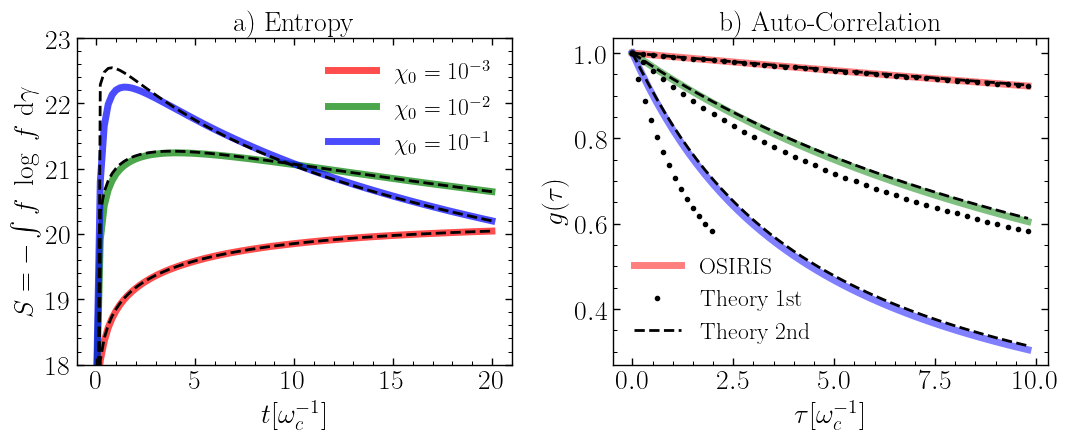

In [9]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
OSIRISlinewidth = 5

# Entropy
th3 = get_entropy(tlst_chi3, 1e-3, g0=1800, s0=0.0)
th2 = get_entropy(tlst_chi2, 1e-2, g0=1800, s0=0.0)
th1 = get_entropy(tlst_chi1, 1e-1, g0=1800, s0=0.0)
#
axes[0].plot(tlst_chi3, Slst_chi3, color='r', linewidth=OSIRISlinewidth, alpha=0.7, label=r'$\chi_0=10^{-3}$')
axes[0].plot(tlst_chi2, Slst_chi2, color='g', linewidth=OSIRISlinewidth, alpha=0.7, label=r'$\chi_0=10^{-2}$')
axes[0].plot(tlst_chi1*2, Slst_chi1, color='b', linewidth=OSIRISlinewidth, alpha=0.7, label=r'$\chi_0=10^{-1}$')
#
axes[0].plot(tlst_chi3, th3-th3[-1]+Slst_chi3[-1], 'k--' )
axes[0].plot(tlst_chi2, th2-th2[-1]+Slst_chi2[-1], 'k--' )
axes[0].plot(tlst_chi1*2, th1-th1[-1]+Slst_chi1[-1], 'k--' )

# Auto-Correlation
axes[1].plot(lags3, corr3, color='r', linewidth=OSIRISlinewidth, alpha=0.5, label=r'OSIRIS') #$\texttt{OSIRIS}$
axes[1].plot(lags2, corr2, color='g', linewidth=OSIRISlinewidth, alpha=0.5)
axes[1].plot(lags1*2, corr1, color='b', linewidth=OSIRISlinewidth, alpha=0.5)

# autocorrelation based on lowest order classical average energy
def get_corr_cl(tau, chi0, g0=1800):
    Rc = alpha * 1800 * chi0
    return log(1 + 2*Rc/3 * tau)/(2*Rc/3 * tau)

# chi 1e-3
tlst = np.linspace(0,10,200) + 1e-5
corrth3 = get_corr_cl(2*tlst, 1e-3)
axes[1].plot(tlst[::5], (corrth3/corrth3[0])[::5], 'k.', label=r'Theory 1st')
# computing g from 2nd order classical trajectory
ttt = np.linspace(0,np.max(lags3),len(lags3)*2)
yyy = np.transpose( [np.array(get_mean(2*ttt, 1e-3, g0=1800))] )
corrth3 = autocorrelation(yyy, yyy*0+1, max_lag3) 
axes[1].plot(lags3, (corrth3/corrth3[0]), 'k--', label=r'Theory 2nd')

# chi 1e-2
tlst = np.linspace(0,10,200) + 1e-5
corrth2 = get_corr_cl(2*tlst, 1e-2)
axes[1].plot(tlst[::5], (corrth2/corrth2[0])[::5], 'k.')
# computing g from 2nd order classical trajectory
ttt = np.linspace(0,np.max(lags3),len(lags3)*2)
yyy = np.transpose( [np.array(get_mean(2*ttt, 1e-2, g0=1800))] )
corrth3 = autocorrelation(yyy, yyy*0+1, max_lag3) 
axes[1].plot(lags3, (corrth3/corrth3[0]), 'k--')

# chi 1e-1
tlst = np.linspace(0,5,200) + 1e-5
corrth1 = get_corr_cl(2*tlst, 1e-1)
axes[1].plot((tlst*2)[:40:3], (corrth1/corrth1[0])[:40:3] , 'k.')
# computing g from 2nd order classical trajectory
ttt = np.linspace(0,np.max(lags1),len(lags1)*2)
yyy = np.transpose( [np.array(get_mean(2*ttt, 1e-1, g0=1800))] )
corrth3 = autocorrelation(yyy, yyy*0+1, max_lag3) 
axes[1].plot(lags1*2, (corrth3/corrth3[0]), 'k--')

axes[0].set_ylim([18,23])
axes[0].set_xlabel(r'$t[\omega_c^{-1}]$')
axes[0].set_ylabel(r'$S=-\int f ~\log ~f~\mathrm{d} \gamma$')
axes[0].set_title('a) Entropy')
axes[0].legend(frameon=False, fontsize=17, ncol=1)
#
axes[1].set_xlabel(r'$\tau[\omega_c^{-1}]$')
axes[1].set_ylabel(r'$g(\tau)$')
axes[1].set_title('b) Auto-Correlation')
axes[1].legend(frameon=False, fontsize=17, ncol=1)
#
asp = 3/4
xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes[0].set_aspect(aspect=asp/axesratio)
#
xmin, xmax = axes[1].get_xlim()
ymin, ymax = axes[1].get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes[1].set_aspect(aspect=asp/axesratio)
#
plt.tight_layout()
#plt.savefig('FokkerPlanckSolution_entropy_correlation.pdf', transparent=True)
plt.show()

# Gaussian ansatz

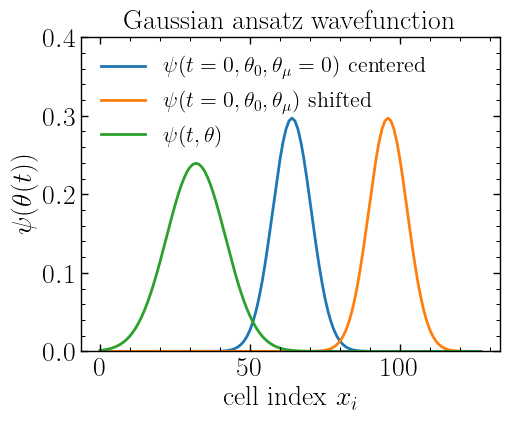

In [3]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(11/2,5))

n = 7
sigma0 = 2**n / 20
x = np.arange(2**n)
mu0 = 2**(n-1)
mu = 2**(n) * 0.75
sigma2 = 2**n / 13
mu2 = 2**(n) * 0.25
psi0 = exp(-0.5*( (x-mu0)/sigma0 )**2); psi0 /= np.sqrt( np.sum(np.abs(psi0)**2) )
plt.plot(x, psi0, label=r'$\psi(t=0, \theta_0, \theta_\mu=0)$ centered')
psi1 = exp(-0.5*( (x-mu)/sigma0 )**2); psi1 /= np.sqrt( np.sum(np.abs(psi1)**2) )
plt.plot(x, psi1, label=r'$\psi(t=0, \theta_0, \theta_\mu)$ shifted')
psi2 = exp(-0.5*( (x-mu2)/sigma2 )**2); psi2 /= np.sqrt( np.sum(np.abs(psi2)**2) )
plt.plot(x, psi2, label=r'$\psi(t, \theta)$')
plt.legend(frameon=False, fontsize=16, ncol=1, loc='upper left')
plt.ylim([0,0.4])
asp = 3/4
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=asp/axesratio)
axes.set_xlabel(r'cell index $x_i$')
axes.set_ylabel(r'$\psi(\theta(t))$')
axes.set_title(r'Gaussian ansatz wavefunction')
plt.tight_layout()
#plt.savefig('Gaussian_ansatz_wavefunction.pdf', transparent=True)
plt.show()